In [4]:
import matplotlib.pyplot as plt

def draw_gt_pred_slices(pred, gt, slice_indices=None, organ_name=""):
    """
    Display slices with ground truth and predicted labels side-by-side.

    Parameters:
    - gt: ground truth mask (slices, H, W)
    - pred: predicted mask (slices, H, W)
    - slice_indices: list of slice indices to visualize
    - organ_name: name to label the plots
    """

    num_slices = gt.shape[0]

    # If no slices are specified, choose 3 evenly spaced slices
    if slice_indices is None:
        slice_indices = np.linspace(0, num_slices - 1, num=3, dtype=int)

    for idx in slice_indices:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[1].imshow(pred[idx], cmap='gray')
        axs[1].set_title(f"raw ({organ_name}) - Slice {idx}")
        axs[1].axis('off')
        axs[0].set_title(f"GT+raw ({organ_name}) - Slice {idx}")
        
        axs[0].imshow(pred[idx], cmap='gray')  # Display the raw image
        axs[0].imshow(gt[idx], cmap='jet', alpha=0.5)  # Overlay the GT with some transparency
        axs[0].axis('off')

        plt.tight_layout()
        plt.draw()
        plt.show()


In [8]:
import SimpleITK as sitk
def sitk_to_array(sitk_img):
    """ Convert SimpleITK image to numpy array with shape (slices, H, W) """
    array = sitk.GetArrayFromImage(sitk.ReadImage(sitk_img))  # Gives shape (slices, H, W)
    return array.astype(np.float32)

In [10]:

import numpy as np
# 1. Load the raw image (not used in this function but you can use it for context if needed)
raw_image = sitk_to_array('truc/feur/UKCHLL061/image.nii.gz')


# 2. Load the predicted segmentation
pred_segmentation = sitk_to_array('truc/feur/testing.nii.gz')
pred_segmentation = pred_segmentation.transpose(2,0,1)

# 3. Load the probabilities (3 classes)
probas = np.load('truc/feur/testing.npz')

# Assuming the probability array is (slices, H, W, num_classes)
# Extract the class probabilities (e.g., for each voxel, select the class with the highest probability)
pred_class = np.argmax(probas['probabilities'], axis=0)  # Shape: (slices, H, W)

# 4. Load the ground truth annotations (three different annotations)
gt_1 = sitk_to_array('truc/feur/UKCHLL061/annotation_1.nii.gz')

gt_2 = sitk_to_array('truc/feur/UKCHLL061/annotation_2.nii.gz')

gt_3 = sitk_to_array('truc/feur/UKCHLL061/annotation_3.nii.gz')


#print(raw_image.shape, gt_1.shape)
# Stack the GT annotations into one array (if you want to visualize them together)
gt = np.stack([gt_1, gt_2, gt_3], axis=0)  # Shape: (3, slices, H, W)

# 5. Draw the slices (for example, visualize slices 0, 10, and 20)
slice_indices = [0, 100, 200, 300]

# Visualize for each organ (or specific ground truth annotation)
#draw_gt_pred_slices(raw_image, gt_2, slice_indices=slice_indices, organ_name="Organ 1")
#draw_gt_pred_slices(gt[0], pred_class, slice_indices=slice_indices, organ_name="Organ 1")
#draw_gt_pred_slices(gt[1], pred_class, slice_indices=slice_indices, organ_name="Organ 2")
#draw_gt_pred_slices(gt[2], pred_class, slice_indices=slice_indices, organ_name="Organ 3")

In [4]:
#Extract metrics
import pandas as pd
df=pd.read_csv("metrics.csv")
for col in df.columns:
    globals()[col] = df[col]


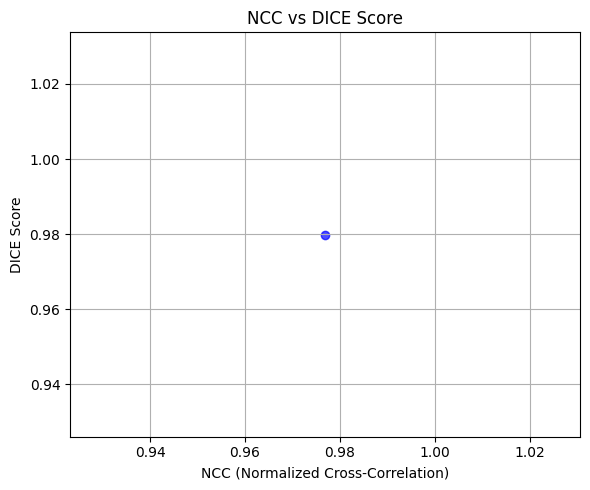

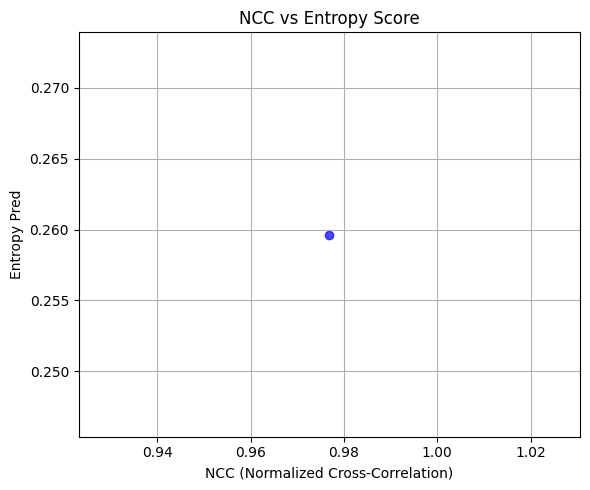

In [20]:
#NCC vs DICE (ou Entropy)

import matplotlib.pyplot as plt
import numpy as np

# Example data: Replace these with your real NCC and DICE values
dice_scores = np.array(DICE_kidn)
ncc_scores = np.array(NCC_12)
entropy_scores = np.array(Entropy_Pred)

plt.figure(figsize=(6, 5))
plt.scatter(ncc_scores, dice_scores, color='blue', alpha=0.7)
plt.xlabel('NCC (Normalized Cross-Correlation)')
plt.ylabel('DICE Score')
plt.title('NCC vs DICE Score')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(ncc_scores, entropy_scores, color='blue', alpha=0.7)
plt.xlabel('NCC (Normalized Cross-Correlation)')
plt.ylabel('Entropy Pred')
plt.title('NCC vs Entropy Score')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
AUROC[0]

"({'panc': 0.07052218534333933, 'kidn': 0.11745471147607224, 'livr': 0.014926499376013395}, {'panc': 0.06886950583287008, 'kidn': 0.11608484810388184, 'livr': 0.014788261954549183})"

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Predicted probability and ground truth

# Binary ground truth

# Create x-axis for CDF (range of possible values: 0 to 1)
x = np.linspace(0, 1, 500)

# CDF of predicted probability (step function centered at pred_prob)
pred_cdf = np.where(x < probas, 0, 1)

# Ground truth CDF (Heaviside step function)
gt_cdf = np.where(x < gt_1, 0, 1)

# Compute CRPS = ∫ (CDF_pred - CDF_gt)^2 dx
crps = np.trapz((pred_cdf - gt_cdf) ** 2, x)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(x, pred_cdf, label='Predicted CDF', color='red')
plt.plot(x, gt_cdf, label='Ground Truth CDF', color='blue')
plt.fill_between(x, pred_cdf, gt_cdf, color='gray', alpha=0.4, label='CRPS Area')
plt.title(f"CRPS Visualization (pred={pred_prob}, gt={gt}) — CRPS = {crps:.4f}")
plt.xlabel("Possible label values")
plt.ylabel("CDF")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


UFuncTypeError: ufunc 'less' did not contain a loop with signature matching types (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

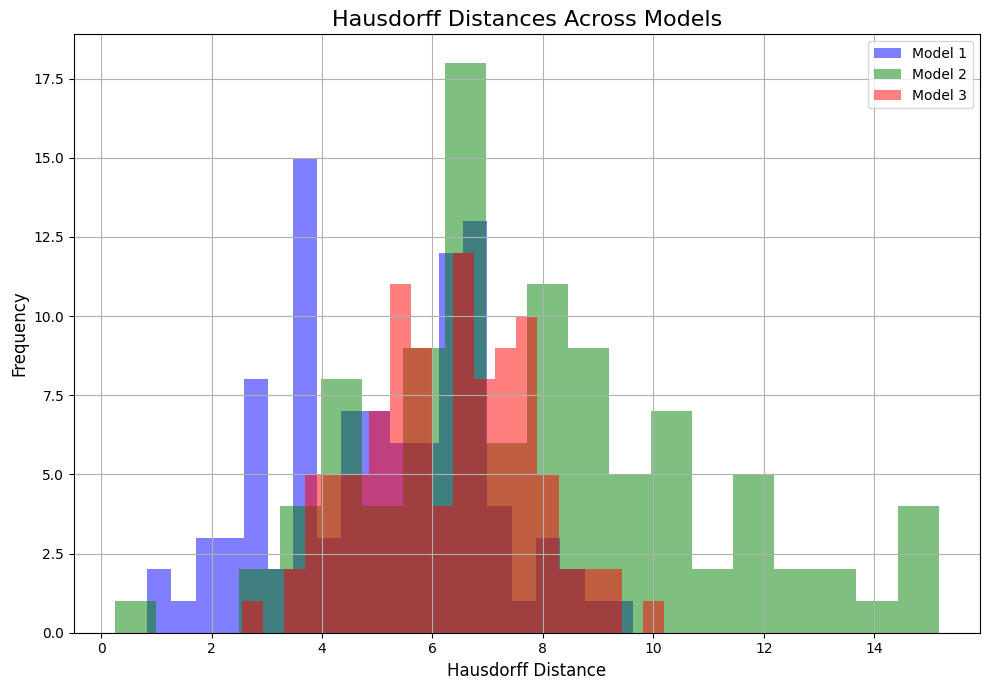

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Example data: Hausdorff distances for different models
hausdorff_model1 = np.random.normal(loc=5, scale=2, size=100)
hausdorff_model2 = np.random.normal(loc=8, scale=3, size=100)
hausdorff_model3 = np.random.normal(loc=6, scale=1.5, size=100)

# Plotting histograms for different models
plt.figure(figsize=(10, 7))

# Plot histograms for each model
plt.hist(hausdorff_model1, bins=20, color='blue', alpha=0.5, label='Model 1')
plt.hist(hausdorff_model2, bins=20, color='green', alpha=0.5, label='Model 2')
plt.hist(hausdorff_model3, bins=20, color='red', alpha=0.5, label='Model 3')

# Add titles and labels
plt.title("Hausdorff Distances Across Models", fontsize=16)
plt.xlabel("Hausdorff Distance", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Add legend
plt.legend()

# Show grid for better visibility
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


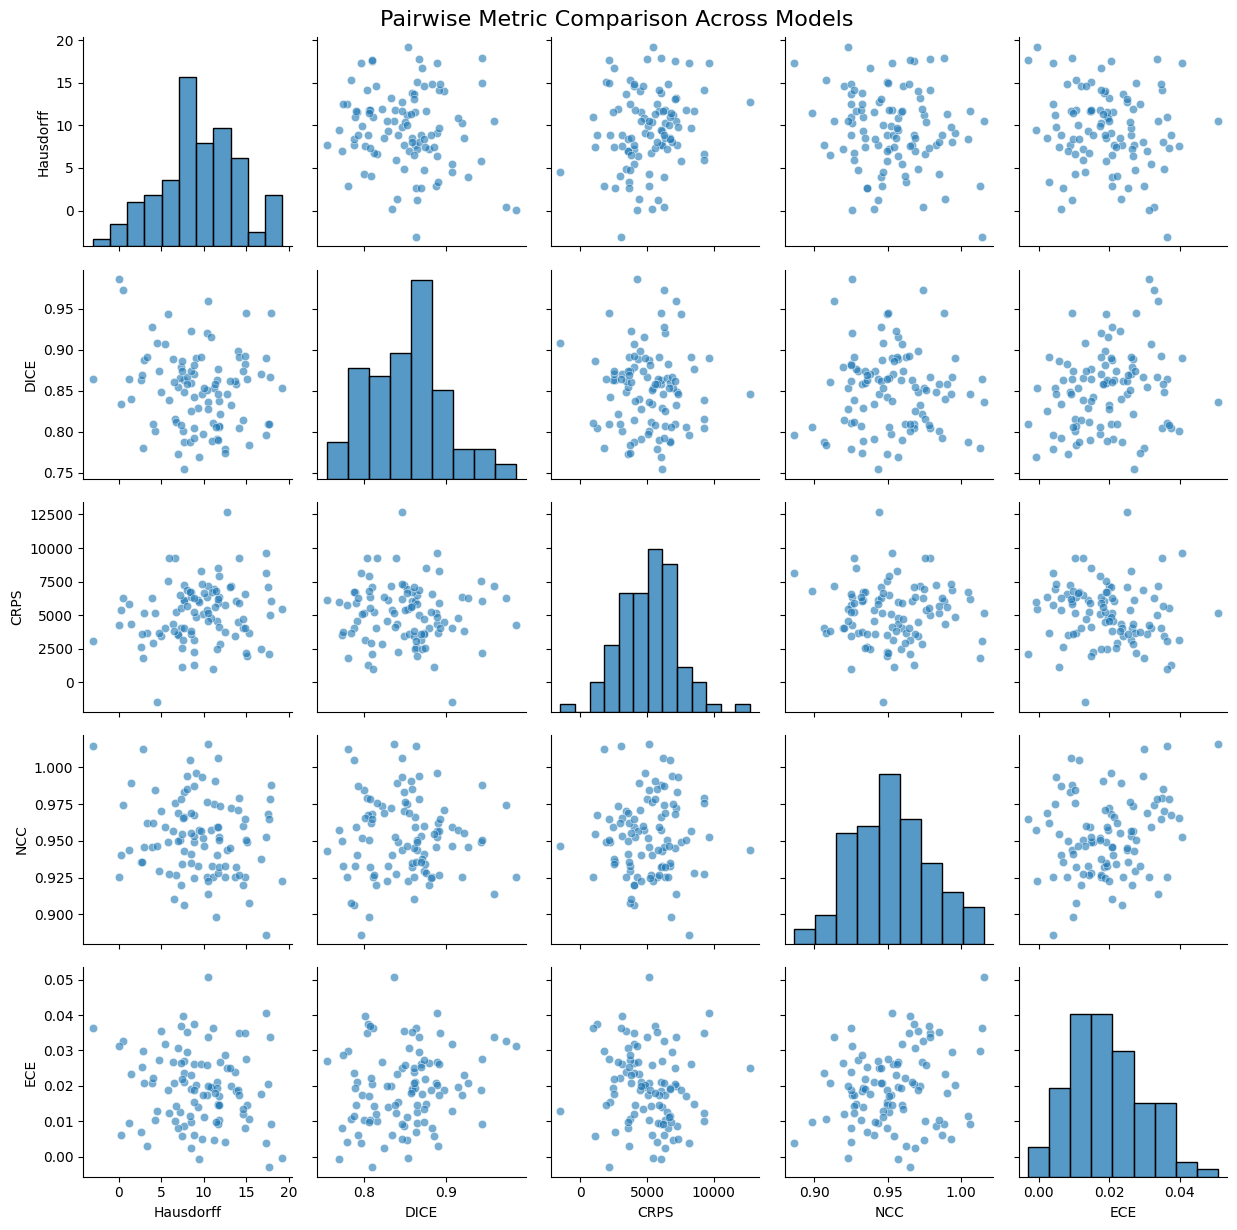

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example data: Simulated metric values for multiple models
# These would be your real metrics for each model
np.random.seed(42)

# Simulating metrics for 100 samples (e.g., Hausdorff, DICE, CRPS, NCC, etc.)
data = {
    'Hausdorff': np.random.normal(loc=10, scale=5, size=100),
    'DICE': np.random.normal(loc=0.85, scale=0.05, size=100),
    'CRPS': np.random.normal(loc=5000, scale=2000, size=100),
    'NCC': np.random.normal(loc=0.95, scale=0.03, size=100),
    'ECE': np.random.normal(loc=0.02, scale=0.01, size=100)
}

# Create a DataFrame
df = pd.DataFrame(data)

# Pairwise plot using Seaborn to visualize the relationship between the metrics
sns.pairplot(df, height=2.5, plot_kws={'alpha':0.6})

# Add title to the plot
plt.suptitle('Pairwise Metric Comparison Across Models', fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
#UNC MAP (mais très emmêlé) --> utile ?
def get_gt_unc_map(self, image_id):
        if self.exp_version.gt_unc_map_loading is None:
            n_reference_segs = self.exp_version.n_reference_segs
            reference_segs_paths = [
                self.ref_seg_dir / f"{image_id}_{i:02d}{self.exp_version.image_ending}"
                for i in range(n_reference_segs)
            ]
            reference_segs = []
            for reference_seg_path in reference_segs_paths:
                reference_seg, _ = load(reference_seg_path)
                reference_segs.append(reference_seg)
            reference_segs = np.array(reference_segs)
            per_pixel_variance = np.var(reference_segs, axis=0)
        else:
            per_pixel_variance = hydra.utils.instantiate(
                self.exp_version.gt_unc_map_loading,
                image_id=image_id,
                dataloader=self.dataloader,
            )
        return per_pixel_variance